## Set-Up

In [4]:
# Imports
import sys
import os
import re
from os.path  import join, isfile
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import krippendorff
from krippendorff import alpha
from bootstrap_alpha import bootstrap
from functions import kippendorff_analysis
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score

In [5]:
# Functions
def extract_info(name):
    pattern = r"(?P<type>\w+)_(?P<model>\w+)_(?P<temperature>\d{2})"
    match = re.match(pattern, name)
    if match:
        info = match.groupdict()
        temperature_str = info['temperature']
        if temperature_str.startswith('0'):
            info['temperature'] = float(f"0.{temperature_str[1]}")  # Convert 01 to 0.1
        else:
            info['temperature'] = float(temperature_str[0])  # Convert 10 to 1.0
        return info
    else:
        raise ValueError(f"Name '{name}' does not match the expected pattern")

def process_names(names): # extract infos from evaluator name
    extracted_info = {}
    for name in names:
        try:
            info = extract_info(name)
            extracted_info[name] = info
        except ValueError as e:
            print(e)
    return extracted_info

def add_details(info_dict, details):
    for name, info in info_dict.items():
        model = info['model']
        if model in details:
            info_dict[name]['specific_model'] = details[model]['specific_model']
            info_dict[name]['provider'] = details[model]['provider']
            #info_dict[name]['introduction_date'] = details[model]['introduction_date']
    return info_dict

def filter_names(info_dict, model_type=None, model=None, temperature=None, specific_model_name=None, introduction_date=None): # filter evaluators based on criteria in dict
    filtered_names = []
    for name, info in info_dict.items():
        if (model_type is None or info['type'] == model_type) and \
           (model is None or info['model'] == model) and \
           (temperature is None or float(info['temperature']) == temperature) and \
           (specific_model_name is None or info.get('specific_model_name') == specific_model_name) and \
           (introduction_date is None or info.get('introduction_date') == introduction_date):
            filtered_names.append(name)
    return filtered_names

def agreement_table(evaluator, subset = None): # transform evaluator_scores into agreement table
    data = globals()[evaluator + '_scores']
    if isinstance(subset, list): # subset 
        data = data[subset]
    cols = data.index # save text numbers as column names for later
    data = data.transpose() # transpose scores
    data.columns = cols # rename columns
    data = data[1:].apply(pd.to_numeric) # convert to numeric

    # transform scores to agreement table ##TODO 
    data = data.melt(value_name='score').groupby(['T', 'score']).size().unstack(fill_value=0)
    data = data.reindex(columns=[1,2,3,4,5], fill_value=0)# reorder columns

    return data

def scores_long(evaluator): # transform evaluator_scores into long format
    data = globals()[evaluator + '_scores']
    data = data.transpose() # transpose scores
    data = data[1:].apply(pd.to_numeric) # convert to numeric
    data = data.melt(value_name='score').set_index('T').rename_axis(evaluator + '_scores_long', axis=('columns'))
    return data

def stats(evaluator):
    data = globals()[evaluator + '_scores']
    data = data.transpose().describe().transpose()[['mean', 'std', 'count', '50%', 'min', 'max']].round(2)
    data['score_mean'] = data['mean'].round(0)
    return data

## Data Preparation

In [6]:
core_texts = [1, 4, 6, 9, 10, 11, 14, 16, 19, 20]
core_texts = [int(x) for x in core_texts]

### LLM

In [7]:
# read in text data --> text_data ##TODO: collect scores from all annotators
text_data = pd.read_csv('Data/texts.csv').drop(columns='Q').reset_index(drop=True)
text_data['T'] = text_data['T'].str.replace('T', '').astype(int)
text_data.set_index('T', inplace=True)
text_data.rename_axis('scores', axis='columns', inplace=True)
text_data[text_data.index.isin(core_texts)]

scores,Text,Source,Industry,Interest Category
T,,,,
1,Find Your Dream Sofa at Westwing: Transform Yo...,GenAI Tool,Consumer Goods and Retail,General Interest
4,Whether you're a seasoned gardener or just sta...,Websearch,Consumer Goods and Retail,General Interest
6,"Chocolate, Sugar Snap and Orange Dessert Recip...",Websearch,Food and Beverage,Professional Interest
9,CHANGE THE WAY YOU MONEY\nFor those who want m...,Websearch,Financial Services and FinTech,General Interest
10,ADUHELM is indicated for the treatment of Alzh...,Websearch,Healthcare and Pharmaceuticals,Professional Interest
11,We have a bold ambition to provide cures for c...,Websearch,Healthcare and Pharmaceuticals,General Interest
14,Go Big With Mini\nDJI Mini 4 Pro is our most a...,Websearch,Technology and Electronics,Special Interest
16,"Welcome to Energy Solutions, Your Partner in P...",ChatGPT 4o,Energy and Environment,General Interest
19,"Welcome, dear readers, to this grand and sumpt...",ChatGPT 4o,Food and Beverage,General Interest


In [8]:
# Define file names
path = 'Data_LLM/'
file_names = [f for f in listdir(path) if isfile(join(path, f))]
evaluators =  [var[:-11].lower() for var in file_names if var.endswith('.csv')]
scores = [evaluator + '_scores'  for evaluator in evaluators]
long = [evaluator + '_long'  for evaluator in evaluators]
len(evaluators)

96

In [9]:
# read in LLM scores
for score in scores:
    df = pd.read_csv(join(path, score + '.csv')).set_index('T').rename_axis(score, axis='columns')
    globals()[score] = df

        # Check if all values in each dataframe are numeric
    if df.map(lambda x: isinstance(x, (int, float))).all().all():
        None
    else:
        print(f"Not all values in {score} are numeric.")



In [10]:
# extract info from evaluators and input specific_model Information
info_dict = process_names(evaluators)

details = {
    "gpt4": {"specific_model": "gpt-4-0613", "provider": "OpenAI"},
    "gpt4t": {"specific_model": "gpt-4-turbo-2024-04-09", "provider": "OpenAI"},
    "gpt35t": {"specific_model": "gpt-3.5-turbo-0125", "provider": "OpenAI"},
    "gpt4o": {"specific_model": "gpt-4o-2024-05-13", "provider": "OpenAI"},
    "mistral7b": {"specific_model": "mistralai/Mistral-7B-Instruct-v0.3", "provider": "MistralAI"},
    "mixtral8x22b": {"specific_model": "mistralai/Mixtral-8x22B-Instruct-v0.1", "provider": "MistralAI"},
    "llama370b": {"specific_model": "meta-llama/Meta-Llama-3-70B-Instruct", "provider": "Meta"},
    "llama38b": {"specific_model": "meta-llama/Meta-Llama-3-8B-Instruct", "provider": "Meta"},
    "llama38b_private": {"specific_model": "gpt-3.5-turbo", "provider": "ommax_vllm"}, # specific_model name is faked for openai compatibility
    "claude3opus": {"specific_model": "claude-3-opus-20240229", "provider": "anthropic"},
    "claude3sonnet": {"specific_model": "claude-3-sonnet-20240229", "provider": "anthropic"},
    "claude3haiku": {"specific_model": "claude-3-haiku-20240307", "provider": "anthropic"},
    "qwen2": {"specific_model": "Qwen/Qwen2-72B-Instruct", "provider": "Qwen"},
    "phi3": {"specific_model": "microsoft/Phi-3-medium-4k-instruct", "provider": "Microsoft"},
    "wizardlm28x22b": {"specific_model": "microsoft/WizardLM-2-8x22B", "provider": "Microsoft"},
    "wizardlm27b": {"specific_model": "microsoft/WizardLM-2-7B", "provider": "Microsoft"},
    "gemma": {"specific_model": "google/gemma-1.1-7b-it", "provider": "Google"},
    "nemotron4340b": {"specific_model": "nvidia/Nemotron-4-340B-Instruct", "provider": "Nvidia"},
}
# details = {
#     "gpt4": {"specific_model": "gpt-4-0613", "provider": datetime(2023, 6, 13)},
#     "gpt35t": {"specific_model": "gpt-3.5-turbo-0125", "provider": datetime(2024, 2, 1)},
#     "gpt4o": {"specific_model": "gpt-4o-2024-05-13", "provider": datetime(2024, 5, 13)},
#     "mistral7b": {"specific_model": "Mistral-7B-Instruct-v0.3", "provider": datetime(2024, 5, 13)}, ## change date
#     "llama370b": {"specific_model": "Meta-Llama-3-70B-Instruct", "provider": datetime(2024, 5, 13)} ## change date
# }
info_dict = add_details(info_dict, details)

for name, info in info_dict.items():
    print(f"{name}: {info}")

vanilla_gpt35t_10: {'type': 'vanilla', 'model': 'gpt35t', 'temperature': 1.0, 'specific_model': 'gpt-3.5-turbo-0125', 'provider': 'OpenAI'}
vanilla_gemma_10: {'type': 'vanilla', 'model': 'gemma', 'temperature': 1.0, 'specific_model': 'google/gemma-1.1-7b-it', 'provider': 'Google'}
vanilla_llama370b_04: {'type': 'vanilla', 'model': 'llama370b', 'temperature': 0.4, 'specific_model': 'meta-llama/Meta-Llama-3-70B-Instruct', 'provider': 'Meta'}
vanilla_qwen2_08: {'type': 'vanilla', 'model': 'qwen2', 'temperature': 0.8, 'specific_model': 'Qwen/Qwen2-72B-Instruct', 'provider': 'Qwen'}
vanilla_gpt4t_06: {'type': 'vanilla', 'model': 'gpt4t', 'temperature': 0.6, 'specific_model': 'gpt-4-turbo-2024-04-09', 'provider': 'OpenAI'}
vanilla_wizardlm27b_02: {'type': 'vanilla', 'model': 'wizardlm27b', 'temperature': 0.2, 'specific_model': 'microsoft/WizardLM-2-7B', 'provider': 'Microsoft'}
vanilla_claude3opus_00: {'type': 'vanilla', 'model': 'claude3opus', 'temperature': 0.0, 'specific_model': 'claude-3

In [11]:
unique_models = {nested_dict['model'] for nested_dict in info_dict.values() if 'model' in nested_dict}

text_score_descriptives = [['model','mean', 'std', 'count', 'min', 'max']]

test_evaluators = filter_names(info_dict, model_type=None, model = None, temperature = None) # select evaluators for  test
merged_df = globals()[test_evaluators[1]+'_scores']
for evaluator in test_evaluators[1:]:
    df = globals()[evaluator+'_scores']
    merged_df = pd.merge(merged_df, df, left_index=True, right_index=True)
    merged_df.columns = [f'Column{i}' for i in range(len(merged_df.columns))]
    

descriptives = merged_df.transpose().describe().transpose().round(2)
descriptives = descriptives.rename_axis('all_LLM_scores', axis='columns')
#descriptives = descriptives[['min', '25%',	'50%','75%','max']].astype(int)

descriptives = pd.DataFrame(descriptives)
descriptives
#text_score_descriptives


all_LLM_scores,count,mean,std,min,25%,50%,75%,max
T,,,,,,,,
1,1920.0,3.26,0.45,2.0,3.0,3.0,4.0,5.0
4,1920.0,3.04,0.52,2.0,3.0,3.0,3.0,5.0
6,1920.0,1.72,1.16,1.0,1.0,1.0,2.0,5.0
9,1920.0,2.28,1.29,1.0,1.0,2.0,3.0,5.0
10,1920.0,1.31,0.59,1.0,1.0,1.0,1.0,4.0
11,1920.0,2.26,0.53,1.0,2.0,2.0,2.0,4.0
14,1920.0,2.12,0.74,1.0,2.0,2.0,2.0,5.0
16,1920.0,3.77,0.55,2.0,4.0,4.0,4.0,5.0
19,1920.0,4.76,0.43,3.0,5.0,5.0,5.0,5.0


### Human

In [27]:
# prepare raw qualtrics data --> qualtrics_transposed
qualtrics = pd.read_csv('Data/Fluff Finder 3.1.csv').drop([0, 1]).reset_index(drop=True).rename_axis('response')
drop_columns = ['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'ResponseId', 'Q_RecaptchaScore']#, 'Q_AmbiguousTextPresent', 'Q_AmbiguousTextQuestions', 'Q_StraightliningCount', 'Q_StraightliningPercentage', 'Q_StraightliningQuestions', 'Q_UnansweredPercentage', 'Q_UnansweredQuestions']
qualtrics = qualtrics.drop(columns=drop_columns)
qualtrics_transposed = qualtrics.transpose()
qualtrics_transposed['block'] = None
qualtrics_transposed['question'] = None

# Define blocks for matching
blocks = {
    'RecordedDate': 'metadata',
    'Introduction': 'metadata',
    'Q2' : int(1),
    'Q3' : 'check',
    'check': 'check',
    'Q4' : 'metadata',
    'Q5' : int(4),
    'Q6' : int(6),
    'Q7' : int(9),
    'Q8' : int(10),
    'Q9' : int(11),
    'Q10': int(14),
    'Q11': int(16),
    'Q12': int(19),
    'Q13': int(20),
    'Q14': int(2),
    'Q15': int(3),
    'Q16': int(5),
    'Q17': int(7),
    'Q18': int(8),
    'Q19': int(12),
    'Q20': int(13),
    'Q21': int(15),
    'Q22': int(17),
    'Q23': int(18),
    'Q24': int(21),
    'count': 'metadata',
    'total': 'metadata',
    'cutoff': 'metadata',
}

# add block column by matching index with blocks dict
for key, value in blocks.items():
    # Check if the key is a substring of any DataFrame's index
    matching_indices = [index for index in qualtrics_transposed.index if key in index]
    # Assign the dictionary value to the new column for matching indices
    for idx in matching_indices:
        qualtrics_transposed.loc[idx, 'block'] = value


# add question column to identify each question
for idx in qualtrics_transposed.index:
    for x in ['_1', '_2', '_3', '_4', '_6', '_7']:
        if x in idx:
            qualtrics_transposed.at[idx, 'question'] = int(re.search(r"_(\d+)", x).group(1))
    if '_5' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'attention_check'
        qualtrics_transposed.at[idx, 'block'] = 'metadata'
    elif '4.1' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'student'
    elif '4.2' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'topic_relevance'
    elif '4.3' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'work_experience'
    elif '.3' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'score'
    elif '.4_F' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'first_click'
    elif '.4_L' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'last_click'
    elif '.4_P' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'page_submit'
    elif '.4_C' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'click_count'
    elif '.5' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'reason'
    elif 'count' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'count'
    elif 'total' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'total'
    elif 'cutoff' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'cutoff'
    elif 'RecordedDate' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'date'
    elif 'Introduction' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'consent'

In [28]:
# create dataset including metadata for all responses and calculate weights
responses = qualtrics_transposed[(qualtrics_transposed['block'] == 'metadata')].set_index('question').drop(['block'], axis='columns').transpose().drop(['date', 'total', 'cutoff'], axis='columns').apply(pd.to_numeric, errors='coerce')

# summarize attention for each response
attention_check_columns = [col for col in responses.columns if 'attention_check' in col]
responses['attention'] = responses[attention_check_columns].mean(axis=1)
responses = responses.drop(attention_check_columns, axis='columns')
responses['attention'] = np.where(responses['attention'] == 4, True, False)
responses['consent'] = np.where(responses['consent'] == 1, True, False)
responses['student'] = np.where(responses['student'] == 1, True, False)
responses['topic_relevance'] = [3 if x == 1 else 2 if x == 4 else 1 if x == 2 else np.nan for x in responses['topic_relevance']] # 3 --> high relevance, 2 --> medium relevance, 1 --> low relevance
responses['work_experience'] = [np.nan if x == 6 else x for x in responses['work_experience']]
responses['weight'] = [a * b * c for a, b, c in zip(responses['topic_relevance'], responses['work_experience'], responses['attention'])] # Define weights for scores

response_weights = responses['weight'].to_dict()

responses

responses[(responses['consent'] == True)]#.index.to_list() # list of evaluations with consent 
#responses[(responses['attention'] == True)].index.to_list() # list of evaluations that pass the attention check

question,consent,student,topic_relevance,work_experience,count,attention,weight
response,,,,,,,
8,True,True,1.0,2.0,11.0,False,0.0
9,True,False,3.0,4.0,12.0,True,12.0
10,True,True,1.0,2.0,8.0,True,2.0
11,True,True,1.0,2.0,7.0,True,2.0
12,True,True,2.0,2.0,7.0,True,4.0
13,True,True,1.0,1.0,7.0,True,1.0
14,True,True,1.0,1.0,12.0,True,1.0
15,True,False,3.0,3.0,13.0,True,9.0
16,True,True,3.0,3.0,8.0,True,9.0


In [29]:
# create human_scores_all and human_scores for analysis similar to llms
human_scores_all = qualtrics_transposed[(qualtrics_transposed['question'] == 'score')].set_index('block').rename_axis('T').rename_axis('human_scores_all', axis='columns').drop('question', axis='columns')
human_scores_all = human_scores_all.apply(pd.to_numeric, errors='coerce')
human_scores = human_scores_all[responses[(responses['consent'] == True)].index.to_list()].rename_axis('human_scores', axis='columns') ##TODO: preliminary  filtering, adapt later!!!
human_scores = human_scores[human_scores.index.isin(core_texts)]
human_scores

human_scores,8,9,10,11,12,13,14,15,16,17,18
T,,,,,,,,,,,
1,4.0,4.0,3.0,4.0,5.0,NaN,5.0,2.0,3.0,4.0,NaN
4,3.0,2.0,1.0,1.0,3.0,3.0,3.0,1.0,NaN,2.0,3.0
6,1.0,1.0,3.0,1.0,1.0,2.0,3.0,3.0,NaN,NaN,1.0
9,1.0,2.0,5.0,NaN,1.0,1.0,1.0,1.0,2.0,1.0,1.0
10,3.0,2.0,NaN,1.0,4.0,NaN,3.0,1.0,4.0,3.0,NaN
11,3.0,3.0,1.0,2.0,NaN,2.0,5.0,2.0,3.0,4.0,3.0
14,1.0,2.0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1.0,1.0
16,2.0,3.0,2.0,4.0,NaN,5.0,3.0,3.0,4.0,3.0,2.0
19,4.0,5.0,NaN,NaN,NaN,4.0,5.0,5.0,NaN,5.0,4.0


In [12]:
data_raw = pd.read_csv('Data/Qualtrics_Export.csv')

# extract all fluff scores
qualtrics = data_raw.filter(regex='\.3$|Q2.1') # extract all third Subquestions which are the human fluff scores
question_nr = [int(x[1:-2]) for x in list(qualtrics.columns[1:])] # extract the question block numbers
text_nr = [str(x-2) for x in question_nr] # create the corresponding text numbers
qualtrics.columns = ['Expert'] + text_nr # rename columns
qualtrics = qualtrics.apply(pd.to_numeric, errors='coerce') # convert to numeric
qualtrics['Expert'] = qualtrics['Expert'].replace({1: False, 2: True}).astype(bool) # convert to boolean
qualtrics.rename_axis('qualtrics', axis='columns', inplace=True)

#qualtrics.iat[5, 11] = 3

# prepare expert scores
experts = qualtrics.loc[qualtrics['Expert'] == True].drop(columns='Expert').reset_index(drop=True) # subset for experts and drop the expert column
experts_stats = experts.describe().transpose()[['mean', 'std', 'count']].round(2).rename_axis('T') # calculate stats for experts
experts_stats['score'] = experts_stats['mean'].round(2) # create a score column
experts_stats.index = experts_stats.index.astype(int) # convert index to int
experts = experts.rename_axis('score').rename_axis('T', axis='columns') # rename axes
experts = experts.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
experts = experts.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
experts = experts.merge(experts_stats, left_index=True, right_index=True, how='left').rename_axis('experts', axis='columns') # merge with the stats
experts = experts[experts.index.isin(core_texts)]
experts.at[11, 'mean'] = 3
experts.at[11, 'score'] = 3

experts

experts,1,2,3,4,5,mean,std,count,score
T,,,,,,,,,
1,0,0,0,1,0,4.0,NaN,1.0,4.0
4,0,0,1,0,0,3.0,NaN,1.0,3.0
6,1,0,0,0,0,1.0,NaN,1.0,1.0
9,1,0,0,0,0,1.0,NaN,1.0,1.0
10,1,0,0,0,0,1.0,NaN,1.0,1.0
11,0,0,0,1,0,3.0,NaN,1.0,3.0
14,1,0,0,0,0,1.0,NaN,1.0,1.0
16,0,0,0,0,1,5.0,NaN,1.0,5.0
19,0,0,0,0,1,5.0,NaN,1.0,5.0


In [13]:
all_scores = experts[['score']].rename(columns={'score': 'experts'}).rename_axis('all_scores', axis = 'columns').astype(int)
all_scores.index.name = 'T'
all_scores


all_scores,experts
T,
1,4
4,3
6,1
9,1
10,1
11,3
14,1
16,5
19,5


In [56]:
def replace_outside_iqr_with_nan(df):
    def replace_outside_iqr(row):
        q1 = row.quantile(0.25)
        q3 = row.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return row.where((row >= lower_bound) & (row <= upper_bound), np.nan)
    
    return df.apply(replace_outside_iqr, axis=1)

data_raw = pd.read_csv('Data/Qualtrics_Export.csv')

# extract all fluff scores
qualtrics_2 = data_raw.filter(regex='\.3$|Q2.1') # extract all third Subquestions which are the human fluff scores
question_nr = [int(x[1:-2]) for x in list(qualtrics_2.columns[1:])] # extract the question block numbers
text_nr = [str(x-2) for x in question_nr] # create the corresponding text numbers
qualtrics_2.columns = ['Expert'] + text_nr # rename columns
qualtrics_2 = qualtrics_2.apply(pd.to_numeric, errors='coerce') # convert to numeric
qualtrics_2['Expert'] = qualtrics_2['Expert'].replace({1: False, 2: True}).astype(bool) # convert to boolean
qualtrics_2.rename_axis('qualtrics_2', axis='columns', inplace=True)

responses_2 = qualtrics_2[['Expert']].rename_axis('response')
responses_2

qualtrics_2 = qualtrics_2.drop(columns=['Expert']).transpose().rename_axis('T').rename_axis('qualtrics_2', axis='columns')
qualtrics_2.index = qualtrics_2.index.astype(int)
qualtrics_2 = qualtrics_2[qualtrics_2.index.isin(core_texts)]
# #qualtrics_2.columns = [str(i) for i in range(24, 38)]

# test_scores = pd.merge(human_scores, qualtrics_2, left_index=True, right_index=True)
# test_scores

# test_clean_scores = replace_outside_iqr_with_nan(test_scores[test_scores.index.isin(core_texts)])
# test_clean_scores

qualtrics_2


qualtrics_2,0,1,2,3,4,5,6,7,8,9,10,11,12,13
T,,,,,,,,,,,,,,
1,NaN,NaN,4.0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.0
6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,3.0
9,NaN,NaN,NaN,1.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,2.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN
14,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
16,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN


In [57]:
# human_final_scores = test_clean_scores[test_clean_scores.index.isin(core_texts)]

# human_final_stats = stats('test_clean')

# human_final_results = [['T', 'mean_w']]

# for index, row in human_final_scores.iterrows():
#     scores = row.where(row.notna() == True).dropna().tolist()
#     raters = row.index.where(row.notna() == True).dropna().tolist()
#     weights = [response_weights[x] for x in raters]
#     total = ( sum(weights))
#     weights_norm = [w / total for w in weights]
#     mean_w = np.dot(scores, weights_norm).round(2)
#     results = [int(index), mean_w]
#     human_final_results.append(results)

# human_final_results = pd.DataFrame(data = human_final_results[1:], columns=human_final_results[0]).set_index('T').rename_axis('human_core_results', axis='columns')

# human_final_stats = human_final_stats.merge(human_final_results['mean_w'], right_index=True, left_index=True)
# human_final_stats['score_mean_w'] = human_final_stats['mean_w'].round(0)
# human_final_stats['score_median_w'] = human_final_stats['50%'].round(0)
# human_final_stats

In [58]:
human_clean_scores = replace_outside_iqr_with_nan(human_scores[human_scores.index.isin(core_texts)])
human_clean_scores

human_clean_stats = stats('human_clean')

human_clean_results = [['T', 'mean_w']]

for index, row in human_clean_scores.iterrows():
    scores = row.where(row.notna() == True).dropna().tolist()
    raters = row.index.where(row.notna() == True).dropna().tolist()
    weights = [response_weights[x] for x in raters]
    total = ( sum(weights))
    weights_norm = [w / total for w in weights]
    mean_w = np.dot(scores, weights_norm).round(2)
    results = [int(index), mean_w]
    human_clean_results.append(results)

human_clean_results = pd.DataFrame(data = human_clean_results[1:], columns=human_clean_results[0]).set_index('T').rename_axis('human_clean_results', axis='columns')

human_clean_stats = human_clean_stats.merge(human_clean_results['mean_w'], right_index=True, left_index=True).rename_axis('human_clean_stats', axis='columns')
human_clean_stats['score_mean_w'] = human_clean_stats['mean_w'].round(0)
human_clean_stats

human_clean_stats,mean,std,count,50%,min,max,score_mean,mean_w,score_mean_w
T,,,,,,,,,
1,3.58,1.00,12.0,4.0,2.0,5.0,4.0,3.36,3.0
4,2.27,0.90,11.0,3.0,1.0,3.0,2.0,1.95,2.0
6,1.82,0.98,11.0,1.0,1.0,3.0,2.0,1.83,2.0
9,1.00,0.00,9.0,1.0,1.0,1.0,1.0,1.00,1.0
10,2.73,1.35,11.0,3.0,1.0,5.0,3.0,2.56,3.0
11,2.85,1.21,13.0,3.0,1.0,5.0,3.0,2.79,3.0
14,1.45,0.69,11.0,1.0,1.0,3.0,1.0,1.65,2.0
16,3.25,1.06,12.0,3.0,2.0,5.0,3.0,3.34,3.0
19,4.67,0.50,9.0,5.0,4.0,5.0,5.0,4.95,5.0


In [59]:
human_stats = stats('human')
human_stats

,mean,std,count,50%,min,max,score_mean
T,,,,,,,
1,3.58,1.00,12.0,4.0,2.0,5.0,4.0
4,2.27,0.90,11.0,3.0,1.0,3.0,2.0
6,1.82,0.98,11.0,1.0,1.0,3.0,2.0
9,1.50,1.17,12.0,1.0,1.0,5.0,2.0
10,2.73,1.35,11.0,3.0,1.0,5.0,3.0
11,2.85,1.21,13.0,3.0,1.0,5.0,3.0
14,1.45,0.69,11.0,1.0,1.0,3.0,1.0
16,3.25,1.06,12.0,3.0,2.0,5.0,3.0
19,4.67,0.50,9.0,5.0,4.0,5.0,5.0


In [60]:
human_core_scores = human_scores[human_scores.index.isin(core_texts)]

human_core_stats = stats('human_clean')

human_core_results = [['T', 'mean_w']]

for index, row in human_core_scores.iterrows():
    scores = row.where(row.notna() == True).dropna().tolist()
    raters = row.index.where(row.notna() == True).dropna().tolist()
    weights = [response_weights[x] for x in raters]
    total = ( sum(weights))
    weights_norm = [w / total for w in weights]
    mean_w = np.dot(scores, weights_norm).round(2)
    results = [int(index), mean_w]
    human_core_results.append(results)

human_core_results = pd.DataFrame(data = human_core_results[1:], columns=human_core_results[0]).set_index('T').rename_axis('human_core_results', axis='columns')

human_core_stats = human_core_stats.merge(human_core_results['mean_w'], right_index=True, left_index=True)
human_core_stats['score_mean_w'] = human_core_stats['mean_w'].round(0)
human_core_stats['score_median_w'] = human_core_stats['50%'].round(0)
human_core_stats

,mean,std,count,50%,min,max,score_mean,mean_w,score_mean_w,score_median_w
T,,,,,,,,,,
1,3.58,1.00,12.0,4.0,2.0,5.0,4.0,3.36,3.0,4.0
4,2.27,0.90,11.0,3.0,1.0,3.0,2.0,1.95,2.0,3.0
6,1.82,0.98,11.0,1.0,1.0,3.0,2.0,1.83,2.0,1.0
9,1.00,0.00,9.0,1.0,1.0,1.0,1.0,1.55,2.0,1.0
10,2.73,1.35,11.0,3.0,1.0,5.0,3.0,2.56,3.0,3.0
11,2.85,1.21,13.0,3.0,1.0,5.0,3.0,2.79,3.0,3.0
14,1.45,0.69,11.0,1.0,1.0,3.0,1.0,1.65,2.0,1.0
16,3.25,1.06,12.0,3.0,2.0,5.0,3.0,3.34,3.0,3.0
19,4.67,0.50,9.0,5.0,4.0,5.0,5.0,4.95,5.0,5.0


In [61]:
human_core_results

human_core_results,mean_w
T,
1,3.36
4,1.95
6,1.83
9,1.55
10,2.56
11,2.79
14,1.65
16,3.34
19,4.95


In [62]:
averages = human_clean_stats[['mean_w']].rename_axis('averages T= .6', axis='columns')

test_evaluators = filter_names(info_dict, model_type='vanilla', model =None, temperature = 0.6) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    mean = stats(evaluator)['mean']
    model = info_dict[evaluator]['model']

    averages[model] = mean

averages

averages T= .6,mean_w,gpt4t,llama38b,gpt4,llama370b,mistral7b,claude3haiku,gpt35t,gpt4o,claude3sonnet,mixtral8x22b,claude3opus
T,,,,,,,,,,,,
1,3.36,3.80,3.05,3.10,3.05,3.0,3.15,3.65,3.45,4.00,3.05,4.00
4,1.95,2.15,3.05,2.00,3.00,3.0,3.00,3.95,3.25,3.85,3.00,3.05
6,1.83,1.85,1.00,1.00,1.20,1.1,2.90,3.75,1.00,4.15,1.10,3.60
9,1.00,4.00,1.55,1.85,1.50,1.5,4.00,4.50,1.90,4.70,1.50,2.90
10,2.56,1.00,1.05,1.00,1.00,1.0,1.95,3.05,1.00,2.00,1.05,2.00
11,2.79,2.20,2.00,2.00,2.00,2.0,2.25,3.65,2.75,2.75,2.00,3.05
14,1.65,1.00,2.00,1.00,2.00,2.0,2.15,3.55,1.85,3.80,2.00,2.65
16,3.34,3.90,4.00,2.10,4.00,4.0,3.05,3.35,3.80,4.15,4.00,4.00
19,4.95,4.00,5.00,4.45,5.00,5.0,4.10,4.05,5.00,5.00,5.00,4.65


In [63]:
scores = human_clean_stats[['score_mean_w']].astype(int).rename_axis('scores T= .6', axis='columns')

test_evaluators = filter_names(info_dict, model_type=None, model =None, temperature = 0.6) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    score = stats(evaluator)['score_mean'].round(0).astype(int)
    model = info_dict[evaluator]['model']

    scores[model] = score

scores

scores T= .6,score_mean_w,gpt4t,llama38b,gpt4,llama370b,mistral7b,claude3haiku,gpt35t,gpt4o,claude3sonnet,mixtral8x22b,claude3opus
T,,,,,,,,,,,,
1,3,4,3,3,3,3,3,4,3,4,3,4
4,2,2,3,2,3,3,3,4,3,4,3,3
6,2,2,1,1,1,1,3,4,1,4,1,4
9,1,4,2,2,2,2,4,4,2,5,2,3
10,3,1,1,1,1,1,2,3,1,2,1,2
11,3,2,2,2,2,2,2,4,3,3,2,3
14,2,1,2,1,2,2,2,4,2,4,2,3
16,3,4,4,2,4,4,3,3,4,4,4,4
19,5,4,5,4,5,5,4,4,5,5,5,5


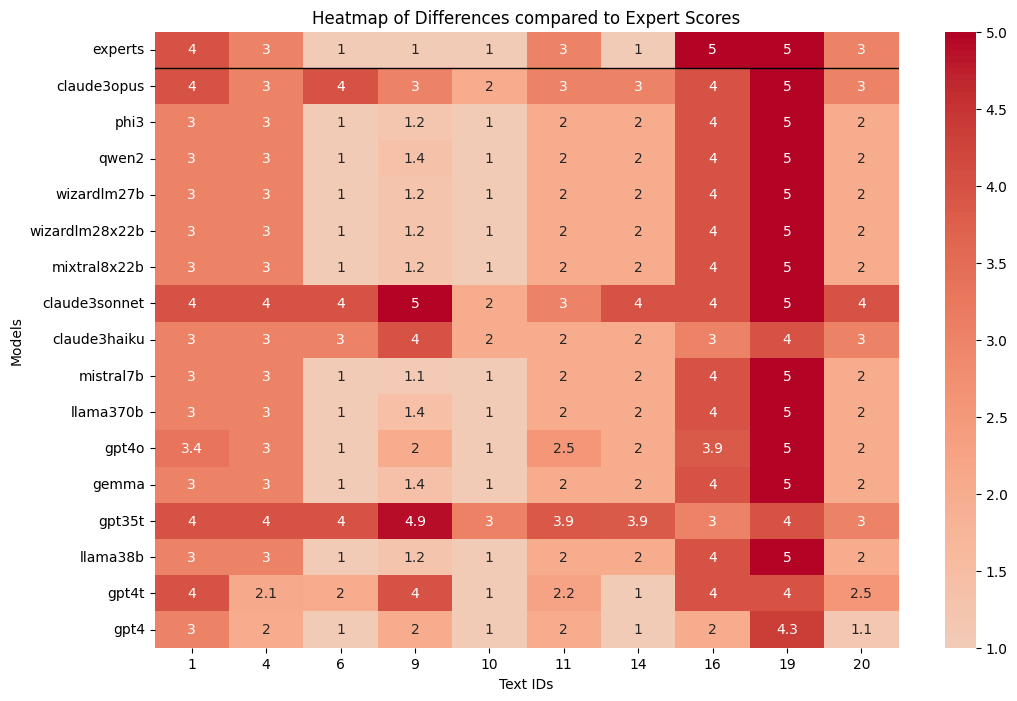

In [15]:
all_scores_00 = experts[['score']].rename(columns={'score': 'experts'}).rename_axis('all_scores_00', axis = 'columns').astype(int)
all_scores_00.index.name = 'T'
all_scores_00

test_evaluators = filter_names(info_dict, model_type=None, model =None, temperature = 0) # select evaluators for  test


for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    score = stats(evaluator)['mean'].round(2)
    model = info_dict[evaluator]['model']

    all_scores_00[model] = score

all_scores_00

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(all_scores_00.transpose(), annot=True, cmap='coolwarm', center=0)

plt.axhline(y=1, color='black', linewidth=1)


plt.title('Heatmap of Differences compared to Expert Scores')
plt.ylabel('Models')
plt.xlabel('Text IDs')
plt.show()

In [33]:
all_scores_10 = experts[['score']].rename(columns={'score': 'experts'}).rename_axis('all_scores_10', axis = 'columns').astype(int)
all_scores_10.index.name = 'T'
all_scores_10

test_evaluators = filter_names(info_dict, model_type=None, model =None, temperature = 1) # select evaluators for  test


for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    score = stats(evaluator)['score_mean'].round(0).astype(int)
    model = info_dict[evaluator]['model']

    all_scores_10[model] = score

all_scores_10

all_scores_10,experts,gpt35t,gemma,gpt4o,llama370b,mistral7b,claude3haiku,gpt4,gpt4t,llama38b,qwen2,phi3,claude3opus,claude3sonnet,mixtral8x22b,wizardlm28x22b,wizardlm27b
T,,,,,,,,,,,,,,,,,
1,4,4,3,3,3,3,3,3,4,3,3,3,4,4,3,3,3
4,3,4,3,4,3,3,3,2,2,3,3,3,3,4,3,3,3
6,1,4,1,1,1,1,3,1,2,1,1,1,4,4,1,1,1
9,1,5,2,2,1,2,4,2,4,2,2,2,3,5,1,2,1
10,1,3,1,1,1,1,2,1,1,1,1,1,2,2,1,1,1
11,3,4,2,3,2,2,2,2,2,2,2,2,3,3,2,2,2
14,1,4,2,2,2,2,2,1,1,2,2,2,2,4,2,2,2
16,5,3,4,4,4,4,3,2,4,4,4,4,4,4,4,4,4
19,5,4,5,5,5,5,4,5,4,5,5,5,5,5,5,5,5


In [34]:
all_changeses_00_10 = all_scores_10 - all_scores_00
all_changeses_00_10

,claude3haiku,claude3opus,claude3sonnet,experts,gemma,gpt35t,gpt4,gpt4o,gpt4t,llama370b,llama38b,mistral7b,mixtral8x22b,phi3,qwen2,wizardlm27b,wizardlm28x22b
T,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0,0.0,0.00,0.00,-0.35,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
4,0.0,0.0,0.0,0,0.0,0.00,0.00,1.00,-0.10,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
6,0.0,0.0,0.0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
9,0.0,0.0,0.0,0,0.6,0.10,0.00,0.00,0.00,-0.45,0.75,0.95,-0.25,0.8,0.65,-0.25,0.75
10,0.0,0.0,0.0,0,0.0,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
11,0.0,0.0,0.0,0,0.0,0.10,0.00,0.45,-0.25,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
14,0.0,-1.0,0.0,0,0.0,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
16,0.0,0.0,0.0,0,0.0,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
19,0.0,0.0,0.0,0,0.0,0.00,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00


In [35]:
test_evaluators = filter_names(info_dict, model_type=None, model ='gpt4o', temperature = None) # select evaluators for  test
test_evaluators
# #gpt4o_dev = [[0, 0.2, 0.4, 0.6, 0.8, 1]]

# for i, model in enumerate(test_evaluators):
#     scores = stats(model)['score_mean'].round(0).astype(int)
#     temp  = info_dict[model]['temperature']

#     print(temp)




# # stats('vanilla_gpt4o_00')['score_mean'].round(0).astype(int)

['vanilla_gpt4o_10',
 'vanilla_gpt4o_04',
 'vanilla_gpt4o_06',
 'vanilla_gpt4o_08',
 'vanilla_gpt4o_00',
 'vanilla_gpt4o_02']

In [36]:
all_differences = experts[['score']].rename(columns={'score': 'experts'}).rename_axis('all_differences', axis = 'columns')
all_differences = all_differences.drop(columns=['experts'])

all_differences.index.name = 'T'

for i, model in enumerate(list(all_scores_00.columns)[1:]): # concat long dataframes
    difference = all_scores_00[model] - all_scores_00['experts']

    all_differences[model] = difference

all_differences = all_differences.sort_index(axis=1)
all_differences.insert(0, 'Expert Scores ', all_scores_00['experts'])

#all_differences['experts'] = all_scores['experts']

all_differences
#all_scores.columns


all_differences,Expert Scores,claude3haiku,claude3opus,claude3sonnet,gemma,gpt35t,gpt4,gpt4o,gpt4t,llama370b,llama38b,mistral7b,mixtral8x22b,phi3,qwen2,wizardlm27b,wizardlm28x22b
T,,,,,,,,,,,,,,,,,
1,4,-1.0,0.0,0.0,-1.0,0.00,-1.00,-0.65,0.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00
4,3,0.0,0.0,1.0,0.0,1.00,-1.00,0.00,-0.90,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
6,1,2.0,3.0,3.0,0.0,3.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
9,1,3.0,2.0,4.0,0.4,3.90,1.00,1.00,3.00,0.45,0.25,0.05,0.25,0.2,0.35,0.25,0.25
10,1,1.0,1.0,1.0,0.0,2.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
11,3,-1.0,0.0,0.0,-1.0,0.90,-1.00,-0.45,-0.75,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00
14,1,1.0,2.0,3.0,1.0,2.85,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00
16,5,-2.0,-1.0,-1.0,-1.0,-2.00,-3.00,-1.15,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00
19,5,-1.0,0.0,0.0,0.0,-1.00,-0.65,0.00,-1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00


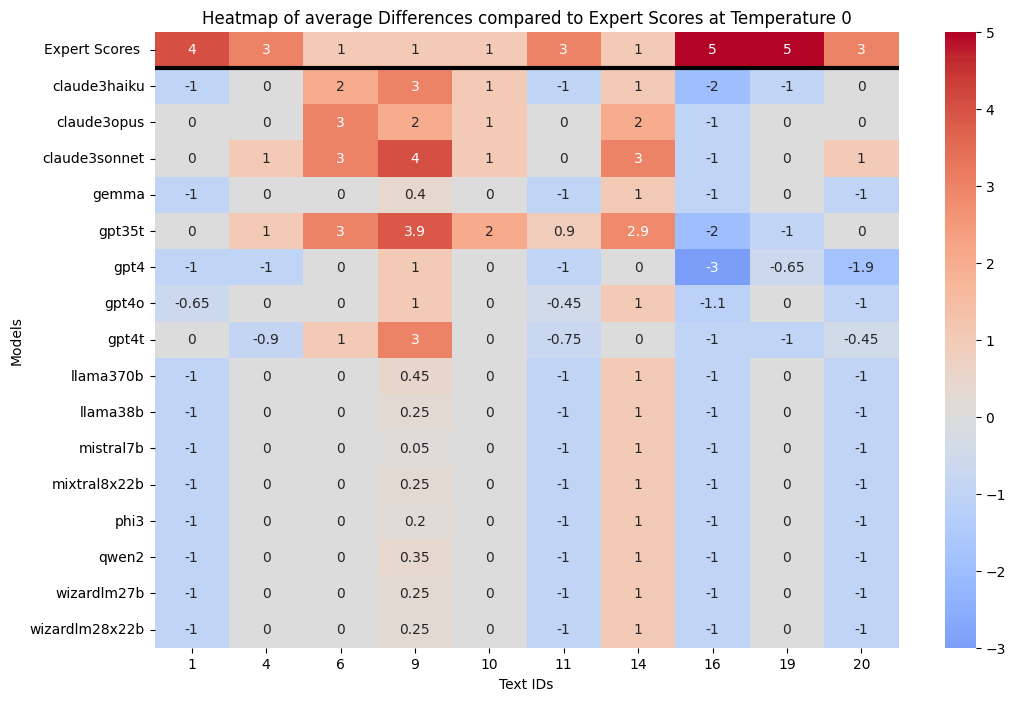

In [37]:
# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(all_differences.transpose(), annot=True, cmap='coolwarm', center=0)

plt.axhline(y=1, color='black', linewidth=3)


plt.title('Heatmap of average Differences compared to Expert Scores at Temperature 0')
plt.ylabel('Models')
plt.xlabel('Text IDs')
plt.show()

## LLM only analyses

### Effect of Model Complexity on ICC

In [72]:
# # Run Kippendorff Analysis
# # Settings
# name = 'kippendorff_H1' # Define Name
# test_evaluators = filter_names(info_dict, model_type='vanilla', model = None, temperature=1) # select evaluators for  test

# # run analysis
# locals()[name] = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# # iterate through test evaluators
# for i, evaluator in enumerate(test_evaluators):
#     data = agreement_table(evaluator)
#     alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
#     data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
#     locals()[name].append(data)


# # reformat into df
# locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
# locals()[name]

In [73]:
# # Visualize Kippendorff 
# name = name

# # add relevant data to df from info_dict'
# df = locals()[name]
# df['introduction_date'] = df.index.map(lambda x: info_dict[x]['introduction_date'])

# start_date = datetime(2023, 1, 1)
# df['introduction_date_numeric'] = (df['introduction_date'] - start_date).dt.days

# # Plotting
# plt.figure(figsize=(6, 3))
# sns.regplot(x='introduction_date_numeric', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}) # , ci = None  to remove confidence interval
# #plt.scatter(df['introduction_date'], df['lb_ci_95_1s'], color='blue')
# plt.title('Inter Rater Reliability (IRR) vs Model Introduction Date')
# plt.xlabel('Introduction of underlying model')
# plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
# plt.grid(True)

# plt.ylim(-0.2,1)
# plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
# plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')
# #plt.xlim(datetime(2023, 1, 1),datetime(2024, 7, 1))

# # Annotate points with the model names
# for idx, row in df.iterrows():
#         plt.annotate(idx, (row['introduction_date_numeric'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

# # Convert x-ticks back to datetime for readability
# plt.xticks(
#     ticks=df['introduction_date_numeric'],
#     labels=df['introduction_date'].dt.strftime('%Y-%m-%d'),
#     rotation=45
# )


# plt.show()

### Effect of Temperature on ICC

In [40]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H2' # Define Name
test_evaluators = filter_names(info_dict, model_type=None, model =None, temperature = None) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'ci_95_2s', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, ci_95_2s, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

kippendorff_H2,ci_95_2s,alpha,c_reliable,c_tentative,c_unreliable,lb_ci_95_1s
evaluator,,,,,,
vanilla_gpt35t_10,"[0.21534594311028207, 0.31454083119608295]",0.342679,0.0,0.0,1.0,0.222721
vanilla_gemma_10,"[0.9329701834862385, 0.9454128440366972]",0.950229,1.0,1.0,0.0,0.934164
vanilla_llama370b_04,"[0.975926195501856, 0.983377611179853]",0.983951,1.0,1.0,0.0,0.976690
vanilla_qwen2_08,"[0.9452146395675187, 0.9560925992201774]",0.959653,1.0,1.0,0.0,0.946391
vanilla_gpt4t_06,"[0.9120575221238938, 0.9261666897123894]",0.934458,1.0,1.0,0.0,0.913302
...,...,...,...,...,...,...
vanilla_gpt4_00,"[0.9424380991971733, 0.9555327496167736]",0.963990,1.0,1.0,0.0,0.943257
vanilla_gpt35t_02,"[0.5426414106145252, 0.6104661312849162]",0.725035,0.0,0.0,1.0,0.548141
vanilla_qwen2_06,"[0.9756134316715127, 0.9834320260974398]",0.983618,1.0,1.0,0.0,0.976358


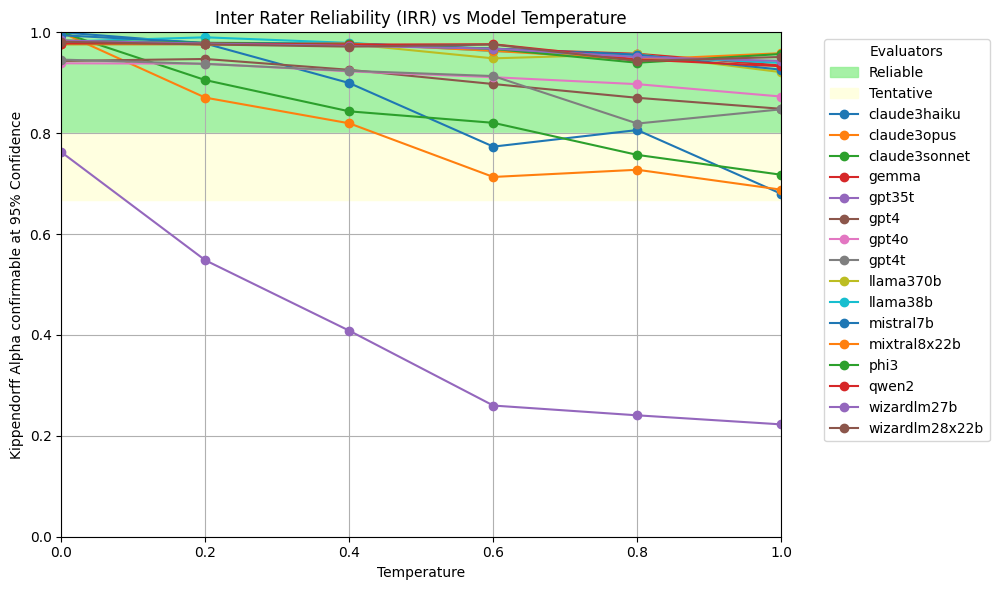

In [98]:
# Visualize Kippendorff 
name = 'kippendorff_H2'

# add relevant data to df from info_dict'
df = locals()[name]
df['temperature'] = df.index.map(lambda x: info_dict[x]['temperature'])
df['model'] = df.index.map(lambda x: info_dict[x]['model'])

model_info = info_dict.get(model)
df['provider'] = df['model'].map(lambda x: details[x]['provider'])
# df = df[df['provider'] == 'anthropic']
df = df.sort_values('model', ascending= True)

# Plotting
plt.figure(figsize=(12, 6))
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='Reliable')
plt.axhspan(0.667, 0.8, color='lightyellow', alpha=1, label='Tentative')


# Plot each evaluator
for model in df['model'].unique():
    model_df = df[df['model'] == model].sort_values('temperature', ascending=False)
    plt.plot(model_df['temperature'], model_df['lb_ci_95_1s'], marker='o', label=model)

plt.title('Inter Rater Reliability (IRR) vs Model Temperature')
plt.xlabel('Temperature')
plt.ylabel('Kippendorff Alpha confirmable at 95% Confidence')
# Place the legend outside the plot
plt.legend(title='Evaluators', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
plt.show()



In [45]:
import statsmodels.formula.api as smf

# Assuming df is the dataframe with columns: temperature, irr, and llm
# Fit the multilevel model
model = smf.mixedlm('lb_ci_95_1s ~ temperature', df, groups=df['model'], re_formula='~temperature').fit()

# Print the summary of the model
print(model.summary())

# Print the fixed effects
print("Fixed Effects:")
print(model.fe_params)

# Print the random effects
print("Random Effects:")
print(model.random_effects)

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    lb_ci_95_1s
No. Observations:    96         Method:                REML       
No. Groups:          16         Scale:                 0.0008     
Min. group size:     6          Log-Likelihood:        154.8478   
Max. group size:     6          Converged:             Yes        
Mean group size:     6.0                                          
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.961    0.019 49.341 0.000  0.922  0.999
temperature             -0.132    0.037 -3.595 0.000 -0.204 -0.060
Group Var                0.006    0.089                           
Group x temperature Cov  0.009    0.143                           
temperature Var          0.020    0.317                           

Fixed Eff

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [49]:
import pandas as pd
import statsmodels.formula.api as smf

df = globals()['kippendorff_H2']
df = df[df['model'] != 'gpt35t']

dummy_data = pd.DataFrame({
    'temperature': df['temperature'].unique(),
    'lb_ci_95_1s': 1.0,  # Assuming perfect score is 1.0
    'provider': 'Dummy',
    'model': 'Dummy'
})

# Combine the dummy provider data with the original dataframe
df = pd.concat([df, dummy_data], ignore_index=True)

# Assuming df is the dataframe with columns: temperature, irr, and llm

# Convert llm to a categorical variable if it isn't already

# Fit the fixed effects model with interactions
model = smf.ols('lb_ci_95_1s ~ temperature + C(model, Treatment(reference="Dummy")) * temperature', data=df).fit()

# Print the summary of the model
print(model.summary())
df

                            OLS Regression Results                            
Dep. Variable:            lb_ci_95_1s   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     47.08
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           2.07e-33
Time:                        20:16:52   Log-Likelihood:                 265.75
No. Observations:                  96   AIC:                            -467.5
Df Residuals:                      64   BIC:                            -385.4
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

,ci_95_2s,alpha,c_reliable,c_tentative,c_unreliable,lb_ci_95_1s,temperature,model,provider
0,"[0.9329701834862385, 0.9454128440366972]",0.950229,1.0,1.0,0.0,0.934164,1.0,gemma,Google
1,"[0.975926195501856, 0.983377611179853]",0.983951,1.0,1.0,0.0,0.976690,0.4,llama370b,Meta
2,"[0.9452146395675187, 0.9560925992201774]",0.959653,1.0,1.0,0.0,0.946391,0.8,qwen2,Qwen
3,"[0.9120575221238938, 0.9261666897123894]",0.934458,1.0,1.0,0.0,0.913302,0.6,gpt4t,OpenAI
4,"[0.9772467010799669, 0.9839062032029035]",0.984461,1.0,1.0,0.0,0.977617,0.2,wizardlm27b,Microsoft
...,...,...,...,...,...,...,...,...,...
91,NaN,NaN,NaN,NaN,NaN,1.000000,0.4,Dummy,Dummy
92,NaN,NaN,NaN,NaN,NaN,1.000000,0.8,Dummy,Dummy
93,NaN,NaN,NaN,NaN,NaN,1.000000,0.6,Dummy,Dummy
94,NaN,NaN,NaN,NaN,NaN,1.000000,0.2,Dummy,Dummy


In [50]:
import statsmodels.api as sm

# Assuming df is your DataFrame and 'temperature' and 'lb_ci_95_1s' are your columns
X = df['temperature']
y = df['lb_ci_95_1s']

# Add a constant (bias) term to the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the p-values
p_values = model.pvalues
print(p_values)

const          7.349055e-89
temperature    3.524947e-06
dtype: float64


###  Effect of Evaluator Type on ICC

In [ ]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H3' # Define Name
test_evaluators = filter_names(info_dict, model_type=None, model ='gpt4', temperature = 1) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

kippendorff_H3,alpha,c_reliable,c_tentative,c_unreliable,lb_ci_95_1s
evaluator,,,,,
vanilla_gpt4_10,0.840773,0.862,1.0,0.0,0.795312


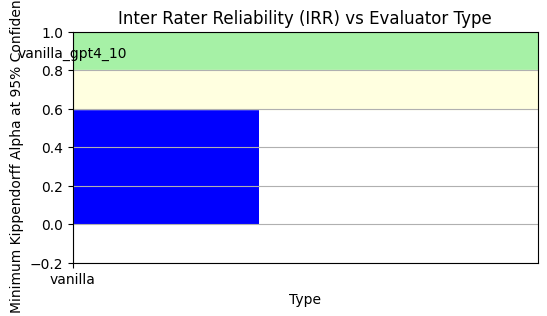

In [ ]:
# Visualize Kippendorff  ##TODO:  Adapt barchart for pairwise comparison
name = name

# add relevant data to df from info_dict'
df = locals()[name]
df['type'] = df.index.map(lambda x: info_dict[x]['type'])


# Plotting
plt.figure(figsize=(6, 3))
#sns.regplot(x='temperature', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}) # , ci = None  to remove confidence interval
plt.bar(df['type'], df['lb_ci_95_1s'], color='blue')
plt.title('Inter Rater Reliability (IRR) vs Evaluator Type')
plt.xlabel('Type')
plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
plt.grid(True)

plt.ylim(-0.2,1)
plt.xlim(0, 1)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')

# Annotate points with the model names
for idx, row in df.iterrows():
        plt.annotate(idx, (row['type'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

### Effect of Model Complexity on Score

In [ ]:
# Run Mixed Effects Model
# Settings
name = 'mixed_effects_H4' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model =None, temperature = 0.0) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    data = scores_long(evaluator)
    data['evaluator'] = evaluator
    if i == 0:
        df = data
    else:
        df = pd.concat([df, data])

# Convert categorical variables to categories
df['evaluator'] = df['evaluator'].astype('category')

# Define the mixed effects model
# The formula 'rating ~ evaluator_class' specifies that we are predicting 'rating' using 'evaluator_class'
# 'text_id' is the grouping variable for random effects
model = mixedlm('score ~ evaluator', df, groups=df.index)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# Print the fixed effects
print("Fixed Effects:")
print(result.fe_params)

# Print the random effects
print("Random Effects:")
print(result.random_effects)

                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        score     
No. Observations:        1330           Method:                    REML      
No. Groups:              10             Scale:                     0.4042    
Min. group size:         133            Log-Likelihood:            -1321.8757
Max. group size:         133            Converged:                 Yes       
Mean group size:         133.0                                               
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          3.400    0.299  11.378 0.000  2.814  3.986
evaluator[T.vanilla_gpt35t_00]     0.305    0.065   4.680 0.000  0.177  0.433
evaluator[T.vanilla_gpt4_00]      -1.442    0.065 -22.109 0.000 -1.570 -1.314
evalua

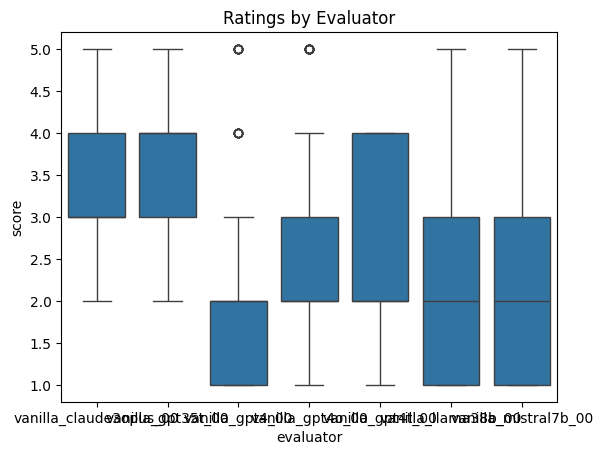

In [ ]:
# Boxplot of ratings by evaluator class
sns.boxplot(x='evaluator', y='score', data=df)
plt.title('Ratings by Evaluator')
plt.show()

### Effect of Temperature on Score

In [53]:
# Run Mixed Effects Model
# Settings
name = 'mixed_effects_H5' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model ='gpt4o', temperature = None) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    data = scores_long(evaluator)
    data['temperature'] = info_dict[evaluator]['temperature'] # add temperature
    if i == 0:
        df = data
    else:
        df = pd.concat([df, data])

df

# Define the mixed effects model
# The formula 'rating ~ evaluator_class' specifies that we are predicting 'rating' using 'evaluator_class'
# 'text_id' is the grouping variable for random effects
model = mixedlm('score ~ temperature', df, groups=df.index)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# Print the fixed effects
print("Fixed Effects:")
print(result.fe_params)

# Print the random effects
print("Random Effects:")
print(result.random_effects)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score    
No. Observations: 1140    Method:             REML     
No. Groups:       10      Scale:              0.1140   
Min. group size:  114     Log-Likelihood:     -418.3246
Max. group size:  114     Converged:          Yes      
Mean group size:  114.0                                
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      2.588    0.401 6.456 0.000  1.802  3.373
temperature    0.005    0.029 0.180 0.857 -0.052  0.063
Group Var      1.603    2.245                          

Fixed Effects:
Intercept      2.587719
temperature    0.005263
dtype: float64
Random Effects:
{1: Group    0.821417
dtype: float64, 4: Group    0.646088
dtype: float64, 6: Group   -1.56306
dtype: float64, 9: Group   -0.668881
dtype: float64, 10: Group   -1.580593
dtype: float64, 

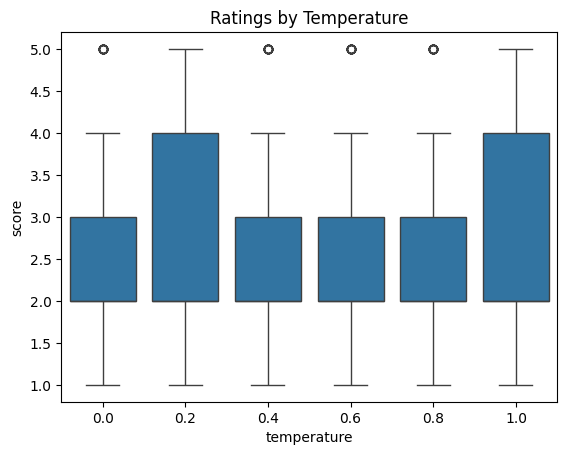

In [ ]:
# Boxplot of ratings by evaluator class
sns.boxplot(x='temperature', y='score', data=df)
plt.title('Ratings by Temperature')
plt.show()

### Effect of Evaluator Type on Score

In [ ]:
# Run Mixed Effects Model
# Settings
name = 'mixed_effects_H6' # Define Name
test_evaluators = filter_names(info_dict, model_type=None, model =None, temperature = 1) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    data = scores_long(evaluator)
    data['type'] = info_dict[evaluator]['type'] # add temperature
    if i == 0:
        df = data
    else:
        df = pd.concat([df, data])

df

# Define the mixed effects model
# The formula 'rating ~ evaluator_class' specifies that we are predicting 'rating' using 'evaluator_class'
# 'text_id' is the grouping variable for random effects
model = mixedlm('score ~ type', df, groups=df.index)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# Print the fixed effects
print("Fixed Effects:")
print(result.fe_params)

# Print the random effects
print("Random Effects:")
print(result.random_effects)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score     
No. Observations: 1330    Method:             REML      
No. Groups:       10      Scale:              0.6949    
Min. group size:  133     Log-Likelihood:     -1670.4824
Max. group size:  133     Converged:          Yes       
Mean group size:  133.0                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   2.753     0.295  9.343  0.000   2.176   3.331
Group Var   0.863     0.493                              

Fixed Effects:
Intercept    2.753383
dtype: float64
Random Effects:
{1: Group    0.641232
dtype: float64, 4: Group    0.267554
dtype: float64, 6: Group   -0.778746
dtype: float64, 9: Group   -0.091178
dtype: float64, 10: Group   -1.339264
dtype: float64, 11: Group   -0.233175
dtype: float64, 14: Group   -0.726431
dtype

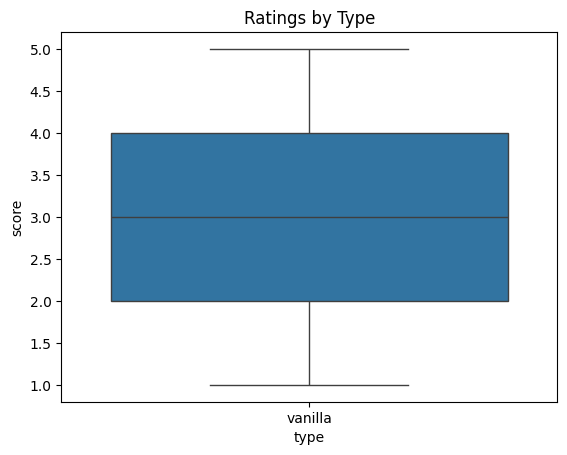

In [ ]:
# Boxplot of ratings by evaluator class
sns.boxplot(x='type', y='score', data=df)
plt.title('Ratings by Type')
plt.show()

## Human Evals

### IRR  of different human score sets

### Summary

In [16]:
# Summarize evaluators
# Settings
name = 'Summary' # Define Name

evaluators = filter_names(info_dict, model_type='vanilla', model = None, temperature=None) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'model', 'alpha', 'lb_ci_95_1s', 'RMSE', 'Accuracy', 'Spearman_rc', 'Spearman_rc_p', 'Cohens_Kappa']]

# iterate through test evaluators
for i, evaluator in enumerate(evaluators):
    data = agreement_table(evaluator)
    statistics = stats(evaluator)
    statistics = statistics[statistics.index.isin(core_texts)]
    
    model = info_dict[evaluator]['model']

    # IRR
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts

    # RMSE
    rmse = root_mean_squared_error(statistics['mean'], all_scores_00['experts'])

    # Accuracy
    acc = accuracy_score(statistics['score_mean'],all_scores_00['experts'])

    # calculate Spearman's Rank Correlation between student and expert fluff scores
    spearman_rc, spearman_rc_p = spearmanr(statistics['mean'], all_scores_00['experts'])


    # calculate Cohen's Kappa between student and expert fluff scores
    cohens_k = cohen_kappa_score(statistics['score_mean'], all_scores_00['experts'])


    data = [evaluator, model, alpha, lb_ci_95_1s, rmse, acc, spearman_rc, spearman_rc_p, cohens_k]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]['RMSE_Inv_N'] = ((1 / locals()[name]['RMSE'] - (1 / locals()[name]['RMSE']).min()) / ((1 / locals()[name]['RMSE']).max() - (1 / locals()[name]['RMSE']).min()))
globals()[name] = locals()[name]

globals()[name]['temperature'] = globals()[name].index.map(lambda x: info_dict[x]['temperature'])
globals()[name]['model'] = globals()[name].index.map(lambda x: info_dict[x]['model'])
globals()[name]['provider'] = globals()[name].index.map(lambda x: info_dict[x]['provider'])
globals()[name] = globals()[name].sort_values(by=['temperature', 'provider', 'model'], ascending=False)

globals()[name]

Summary,model,alpha,lb_ci_95_1s,RMSE,Accuracy,Spearman_rc,Spearman_rc_p,Cohens_Kappa,RMSE_Inv_N,temperature,provider
evaluator,,,,,,,,,,,
vanilla_claude3sonnet_10,claude3sonnet,0.781672,0.717633,1.872498,0.3,0.246978,0.491503,0.195402,0.052302,1.0,anthropic
vanilla_claude3opus_10,claude3opus,0.734642,0.689378,1.264021,0.5,0.756414,0.011341,0.397590,0.302565,1.0,anthropic
vanilla_claude3haiku_10,claude3haiku,0.739332,0.680313,1.336413,0.2,0.538752,0.108094,0.036145,0.260847,1.0,anthropic
vanilla_qwen2_10,qwen2,0.948287,0.932980,0.738072,0.4,0.920190,0.000161,0.277108,0.851373,1.0,Qwen
vanilla_gpt4t_10,gpt4t,0.878853,0.847623,1.155747,0.3,0.618449,0.056650,0.204545,0.374716,1.0,OpenAI
...,...,...,...,...,...,...,...,...,...,...,...
vanilla_wizardlm27b_00,wizardlm27b,0.989104,0.983656,0.711512,0.5,0.913009,0.000225,0.367089,0.900607,0.0,Microsoft
vanilla_phi3_00,phi3,0.989104,0.983656,0.709930,0.5,0.913009,0.000225,0.367089,0.903658,0.0,Microsoft
vanilla_llama38b_00,llama38b,0.987210,0.981172,0.711512,0.5,0.913009,0.000225,0.367089,0.900607,0.0,Meta


In [17]:
descriptive_stats = Summary.groupby('model')['lb_ci_95_1s'].describe().round(2).rename_axis('all_Confirmed_Alphas', axis='columns')
descriptive_stats.to_excel('descriptive_stats.xlsx', engine='openpyxl')

descriptive_stats

all_Confirmed_Alphas,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
claude3haiku,6.0,0.86,0.12,0.68,0.78,0.85,0.96,1.00
claude3opus,6.0,0.80,0.12,0.69,0.72,0.77,0.86,1.00
claude3sonnet,6.0,0.84,0.10,0.72,0.77,0.83,0.89,1.00
gemma,6.0,0.96,0.02,0.93,0.96,0.97,0.98,0.98
gpt35t,6.0,0.41,0.21,0.22,0.25,0.34,0.51,0.76
gpt4,6.0,0.90,0.04,0.85,0.88,0.91,0.94,0.95
gpt4o,6.0,0.91,0.03,0.87,0.90,0.92,0.93,0.94
gpt4t,6.0,0.90,0.05,0.82,0.86,0.92,0.93,0.95
llama370b,6.0,0.96,0.02,0.92,0.95,0.97,0.98,0.98


In [18]:
descriptive_stats = Summary.groupby('model')['RMSE'].describe().round(2).rename_axis('all_RMSEs', axis='columns')
with pd.ExcelWriter('descriptive_stats.xlsx', engine='openpyxl', mode='a') as writer:
    descriptive_stats.to_excel(writer, sheet_name='all_RMSEs')

descriptive_stats

all_RMSEs,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
claude3haiku,6.0,1.43,0.06,1.34,1.41,1.45,1.48,1.49
claude3opus,6.0,1.27,0.06,1.19,1.24,1.26,1.30,1.38
claude3sonnet,6.0,1.89,0.03,1.87,1.87,1.87,1.90,1.95
gemma,6.0,0.72,0.01,0.72,0.72,0.72,0.73,0.73
gpt35t,6.0,1.97,0.07,1.89,1.94,1.96,1.99,2.08
gpt4,6.0,1.22,0.07,1.13,1.16,1.24,1.28,1.30
gpt4o,6.0,0.70,0.03,0.66,0.67,0.69,0.72,0.74
gpt4t,6.0,1.16,0.01,1.15,1.15,1.16,1.16,1.17
llama370b,6.0,0.72,0.01,0.71,0.72,0.72,0.73,0.74


In [19]:
Robustness = Summary.groupby('model')['Spearman_rc_p'].describe().round(2).rename_axis('all_Spearman_rc_p', axis='columns')
with pd.ExcelWriter('descriptive_stats.xlsx', engine='openpyxl', mode='a') as writer:
    descriptive_stats.to_excel(writer, sheet_name='all_Spearman_rc_p')
Robustness

all_Spearman_rc_p,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
claude3haiku,6.0,0.17,0.14,0.06,0.07,0.09,0.27,0.36
claude3opus,6.0,0.01,0.02,0.00,0.00,0.01,0.01,0.04
claude3sonnet,6.0,0.43,0.09,0.30,0.35,0.45,0.49,0.53
gemma,6.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
gpt35t,6.0,0.76,0.20,0.51,0.61,0.79,0.91,0.99
gpt4,6.0,0.00,0.00,0.00,0.00,0.00,0.01,0.01
gpt4o,6.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
gpt4t,6.0,0.04,0.01,0.02,0.03,0.05,0.06,0.06
llama370b,6.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


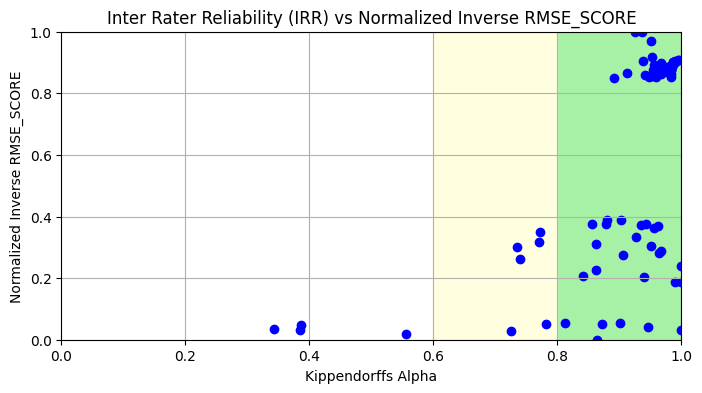

In [75]:
from adjustText import adjust_text

plt.figure(figsize=(8, 4))
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Inter Rater Reliability (IRR) vs Normalized Inverse RMSE_SCORE')
plt.ylabel('Normalized Inverse RMSE_SCORE')
plt.xlabel('Kippendorffs Alpha')
plt.grid(True)

plt.axvspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axvspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')

plt.scatter(Summary['alpha'], Summary['RMSE_Inv_N'], color='blue')


# # Annotate points with the model names
# for idx, row in Summary.iterrows():
#         plt.annotate(idx, (row['alpha'], row['Accuracy']), textcoords="offset points", xytext=(0, 10), ha='center')

# Annotate points with the model names
# texts = []
# for idx, row in Summary.iterrows():
#     texts.append(plt.text(row['alpha'], row['RMSE_Inv_N'], idx))

# # Adjust text to avoid overlapping
# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))


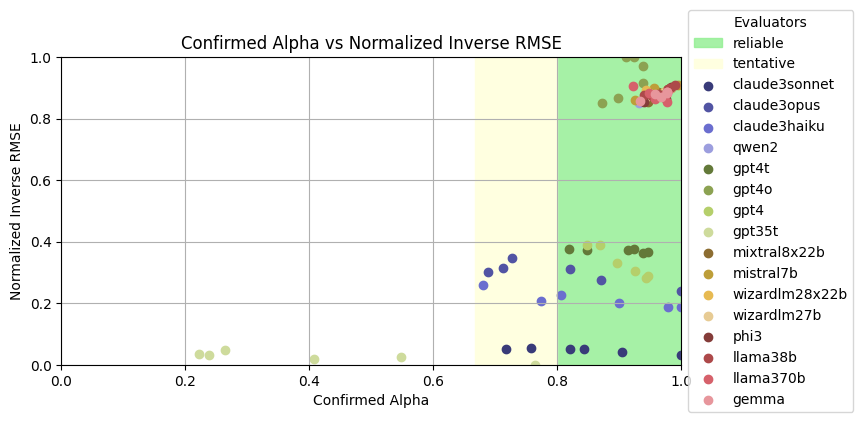

In [119]:
#Summary = Summary[Summary['temperature'] == 0]
df = Summary


plt.figure(figsize=(8, 4))
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Confirmed Alpha vs Normalized Inverse RMSE')
plt.ylabel('Normalized Inverse RMSE')
plt.xlabel('Confirmed Alpha')
plt.grid(True)

plt.axvspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axvspan(0.667, 0.8, color='lightyellow', alpha=1, label='tentative')

#plt.scatter(Summary['alpha'], Summary['RMSE_Inv_N'], color='blue')
# Plot each model's line separately
models = df['model'].unique()
colors = sns.color_palette("tab20b", len(models))

for model, color in zip(models, colors):
    model_df = df[df['model'] == model]
    plt.scatter(model_df['lb_ci_95_1s'], model_df['RMSE_Inv_N'], label=model, color=color)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Evaluators')    

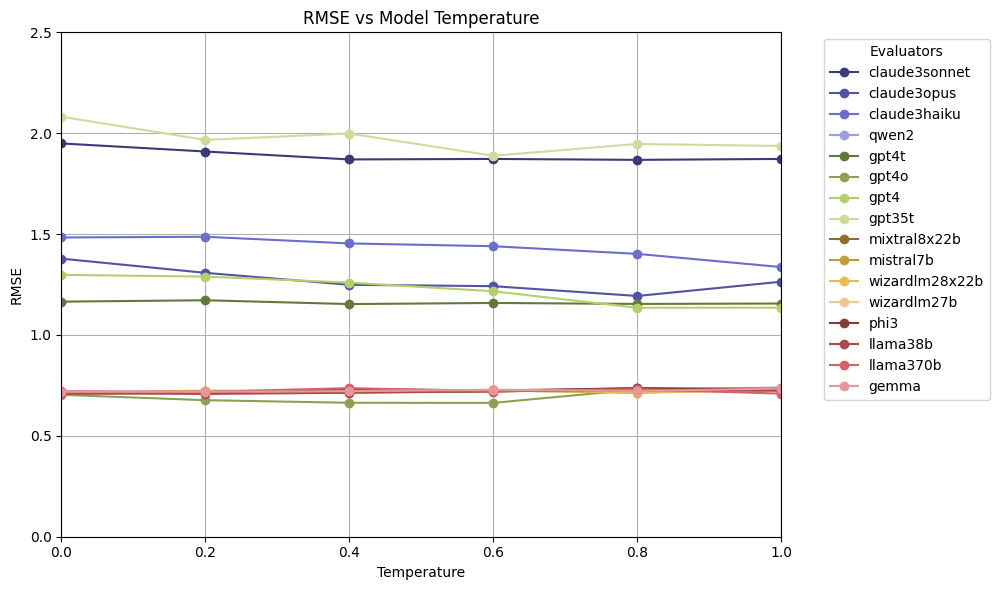

In [83]:
name = 'RMSE' # Define Name
df = globals()['Summary']
#df = df.sort_values('model', ascending=False)

#df = df[df['provider'] == 'anthropic']


# add relevant data to df from info_dict'

# Plotting
plt.figure(figsize=(12, 6))
plt.ylim(0, 2.5)
plt.xlim(0, 1)
# plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='Reliable')
# plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='Tentative')

models = df['model'].unique()
colors = sns.color_palette("tab20b", len(models))

for model, color in zip(models, colors):
    model_df = df[df['model'] == model]
    plt.plot(model_df['temperature'], model_df['RMSE'], label=model, color=color, marker='o')

plt.title('RMSE vs Model Temperature')
plt.xlabel('Temperature')
plt.ylabel('RMSE')

# Place the legend outside the plot
plt.legend(title='Evaluators', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend


plt.show()

In [84]:
# MSE
name = 'RMSE_H11' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model = None, temperature=0.6) # select evaluators for  test



vanilla_gpt4_10_stats = stats('vanilla_gpt4_10')
vanilla_filtered = vanilla_gpt4_10_stats[vanilla_gpt4_10_stats.index.isin(core_texts)]['mean']

root_mean_squared_error(vanilla_filtered, human_core_stats['score_mean_w'])
#mean_absolute_error(vanilla_filtered, human_filtered)

NameError: name 'human_core_stats' is not defined

In [20]:
# OLS Regression - Validity
import pandas as pd
import statsmodels.formula.api as smf
import openpyxl

df = globals()['Summary']
#df['provider'] = df['model'].map(lambda x: MODEL_MAP[x]['provider'])
#df = df.sort_values('model', ascending=False)

dummy_data = pd.DataFrame({
    'temperature': df['temperature'].unique(),
    'RMSE': 0,  # Assuming perfect score is 1.0
    'provider': 'Dummy',
    'model': 'Dummy'
})

# Combine the dummy provider data with the original dataframe
df = pd.concat([df, dummy_data], ignore_index=True)

# Assuming df is the dataframe with columns: temperature, irr, and llm

# Convert llm to a categorical variable if it isn't already

# Fit the fixed effects model with interactions
model = smf.ols('RMSE ~ temperature + C(model, Treatment(reference="Dummy")) * temperature', data=df).fit()

# Print the summary of the model
print(model.summary())

summary = model.summary2().tables[0]  # Get the coefficient table

summary = summary.applymap(lambda x: '{:,.4f}'.format(x) if isinstance(x, (int, float)) else x)


# Save the summary to an Excel file
summary.to_excel('model_summary.xlsx', engine='openpyxl')

# Additional formatting for the thesis
# Adding more statistical details if needed
model_details = {
    'Dep. Variable': 'RMSE',
    'Model': 'OLS',
    'Method': 'Least Squares',
    'No. Observations': model.nobs,
    'Df Residuals': model.df_resid,
    'Df Model': model.df_model,
    'Covariance Type': model.cov_type,
    'R-squared': f"{model.rsquared:.3f}",
    'Adj. R-squared': f"{model.rsquared_adj:.3f}",
    'F-statistic': f"{model.fvalue:.0f}",
    'Prob (F-statistic)': f"{model.f_pvalue:.2E}",
    'Log-Likelihood': f"{model.llf:.2f}",
    'AIC': f"{model.aic:.1f}",
    'BIC': f"{model.bic:.1f}",
    'Omnibus': f"{model.omm:.3f}" if hasattr(model, 'omm') else 'N/A',
    'Prob(Omnibus)': f"{model.omp:.3f}" if hasattr(model, 'omp') else 'N/A',
    'Skew': f"{model.skew:.3f}" if hasattr(model, 'skew') else 'N/A',
    'Prob(JB)': f"{model.jbp:.3f}" if hasattr(model, 'jbp') else 'N/A',
    'Kurtosis': f"{model.kurt:.3f}" if hasattr(model, 'kurt') else 'N/A',
    'Cond. No.': f"{model.condition_number:.1f}"
}

# Create a DataFrame from the model details
details_df = pd.DataFrame(model_details, index=['Model Details']).T

# Save the details to the same Excel file, in a new sheet
with pd.ExcelWriter('model_summary.xlsx', engine='openpyxl', mode='a') as writer:
    details_df.to_excel(writer, sheet_name='Model Details')

print("Model summary and details have been saved to 'model_summary.xlsx'.")

                            OLS Regression Results                            
Dep. Variable:                   RMSE   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1615.
Date:                Wed, 17 Jul 2024   Prob (F-statistic):           1.03e-86
Time:                        21:26:10   Log-Likelihood:                 271.17
No. Observations:                 102   AIC:                            -474.3
Df Residuals:                      68   BIC:                            -385.1
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/var/folders/gq/nyrwnfys5j3dprx6sm_bcrjc0000gn/T/ipykernel_10886/2421282163.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: '{:,.4f}'.format(x) if isinstance(x, (int, float)) else x)


Model summary and details have been saved to 'model_summary.xlsx'.


In [116]:
# OLS Regression - Reliability
import pandas as pd
import statsmodels.formula.api as smf
import openpyxl

df = globals()['Summary']
#df['provider'] = df['model'].map(lambda x: MODEL_MAP[x]['provider'])
#df = df.sort_values('model', ascending=False)

dummy_data = pd.DataFrame({
    'temperature': df['temperature'].unique(),
    'lb_ci_95_1s': 1,  # Assuming perfect score is 1.0
    'provider': 'Dummy',
    'model': 'Dummy'
})

# Combine the dummy provider data with the original dataframe
df = pd.concat([df, dummy_data], ignore_index=True)

# Assuming df is the dataframe with columns: temperature, irr, and llm

# Convert llm to a categorical variable if it isn't already

# Fit the fixed effects model with interactions
model = smf.ols('lb_ci_95_1s ~ temperature + C(model, Treatment(reference="Dummy")) * temperature', data=df).fit()

# Print the summary of the model
print(model.summary())

summary = model.summary2().tables[1]  # Get the coefficient table

summary = summary.applymap(lambda x: '{:,.4f}'.format(x) if isinstance(x, (int, float)) else x)


# Save the summary to an Excel file
summary.to_excel('model2_summary.xlsx', engine='openpyxl')

# Additional formatting for the thesis
# Adding more statistical details if needed
model_details = {
    'Dep. Variable': 'RMSE',
    'Model': 'OLS',
    'Method': 'Least Squares',
    'No. Observations': model.nobs,
    'Df Residuals': model.df_resid,
    'Df Model': model.df_model,
    'Covariance Type': model.cov_type,
    'R-squared': f"{model.rsquared:.3f}",
    'Adj. R-squared': f"{model.rsquared_adj:.3f}",
    'F-statistic': f"{model.fvalue:.0f}",
    'Prob (F-statistic)': f"{model.f_pvalue:.2E}",
    'Log-Likelihood': f"{model.llf:.2f}",
    'AIC': f"{model.aic:.1f}",
    'BIC': f"{model.bic:.1f}",
    'Omnibus': f"{model.omm:.3f}" if hasattr(model, 'omm') else 'N/A',
    'Prob(Omnibus)': f"{model.omp:.3f}" if hasattr(model, 'omp') else 'N/A',
    'Skew': f"{model.skew:.3f}" if hasattr(model, 'skew') else 'N/A',
    'Prob(JB)': f"{model.jbp:.3f}" if hasattr(model, 'jbp') else 'N/A',
    'Kurtosis': f"{model.kurt:.3f}" if hasattr(model, 'kurt') else 'N/A',
    'Cond. No.': f"{model.condition_number:.1f}"
}

# Create a DataFrame from the model details
details_df = pd.DataFrame(model_details, index=['Model Details']).T

# Save the details to the same Excel file, in a new sheet
with pd.ExcelWriter('model2_summary.xlsx', engine='openpyxl', mode='a') as writer:
    details_df.to_excel(writer, sheet_name='Model Details')

print("Model summary and details have been saved to 'model_summary.xlsx'.")

                            OLS Regression Results                            
Dep. Variable:            lb_ci_95_1s   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     96.07
Date:                Fri, 05 Jul 2024   Prob (F-statistic):           1.83e-45
Time:                        10:43:34   Log-Likelihood:                 245.49
No. Observations:                 102   AIC:                            -423.0
Df Residuals:                      68   BIC:                            -333.7
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

/var/folders/gq/nyrwnfys5j3dprx6sm_bcrjc0000gn/T/ipykernel_19281/1743231466.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: '{:,.4f}'.format(x) if isinstance(x, (int, float)) else x)


In [118]:
# OLS Regression - Reliability
import pandas as pd
import statsmodels.formula.api as smf
import openpyxl

df = globals()['Summary']
#df['provider'] = df['model'].map(lambda x: MODEL_MAP[x]['provider'])
#df = df.sort_values('model', ascending=False)


# Assuming df is the dataframe with columns: temperature, irr, and llm

# Convert llm to a categorical variable if it isn't already

# Fit the fixed effects model with interactions
model = smf.ols('lb_ci_95_1s ~ temperature', data=df).fit()

# Print the summary of the model
print(model.summary())

summary = model.summary2().tables[1]  # Get the coefficient table

summary = summary.applymap(lambda x: '{:,.4f}'.format(x) if isinstance(x, (int, float)) else x)


# Save the summary to an Excel file
summary.to_excel('model3_summary.xlsx', engine='openpyxl')

# Additional formatting for the thesis
# Adding more statistical details if needed
model_details = {
    'Dep. Variable': 'RMSE',
    'Model': 'OLS',
    'Method': 'Least Squares',
    'No. Observations': model.nobs,
    'Df Residuals': model.df_resid,
    'Df Model': model.df_model,
    'Covariance Type': model.cov_type,
    'R-squared': f"{model.rsquared:.3f}",
    'Adj. R-squared': f"{model.rsquared_adj:.3f}",
    'F-statistic': f"{model.fvalue:.0f}",
    'Prob (F-statistic)': f"{model.f_pvalue:.2E}",
    'Log-Likelihood': f"{model.llf:.2f}",
    'AIC': f"{model.aic:.1f}",
    'BIC': f"{model.bic:.1f}",
    'Omnibus': f"{model.omm:.3f}" if hasattr(model, 'omm') else 'N/A',
    'Prob(Omnibus)': f"{model.omp:.3f}" if hasattr(model, 'omp') else 'N/A',
    'Skew': f"{model.skew:.3f}" if hasattr(model, 'skew') else 'N/A',
    'Prob(JB)': f"{model.jbp:.3f}" if hasattr(model, 'jbp') else 'N/A',
    'Kurtosis': f"{model.kurt:.3f}" if hasattr(model, 'kurt') else 'N/A',
    'Cond. No.': f"{model.condition_number:.1f}"
}

# Create a DataFrame from the model details
details_df = pd.DataFrame(model_details, index=['Model Details']).T

# Save the details to the same Excel file, in a new sheet
with pd.ExcelWriter('model3_summary.xlsx', engine='openpyxl', mode='a') as writer:
    details_df.to_excel(writer, sheet_name='Model Details')

print("Model summary and details have been saved to 'model_summary.xlsx'.")

                            OLS Regression Results                            
Dep. Variable:            lb_ci_95_1s   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     8.926
Date:                Fri, 05 Jul 2024   Prob (F-statistic):            0.00359
Time:                        12:09:02   Log-Likelihood:                 48.370
No. Observations:                  96   AIC:                            -92.74
Df Residuals:                      94   BIC:                            -87.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9606      0.027     35.932      

/var/folders/gq/nyrwnfys5j3dprx6sm_bcrjc0000gn/T/ipykernel_19281/1707588242.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary = summary.applymap(lambda x: '{:,.4f}'.format(x) if isinstance(x, (int, float)) else x)


In [117]:
# Assuming you have a DataFrame df with columns 'temperature', 'RMSE', and 'model'
model_names = df['provider'].unique()
results = {}

for model_name in model_names:
    model_df = df[df['provider'] == model_name]
    X = sm.add_constant(model_df['temperature'])
    y = model_df['RMSE']
    model = sm.OLS(y, X).fit()
    results[model_name] = model.summary()

for model_name, summary in results.items():
    print(f"Model: {model_name}")
    print(summary)

Model: anthropic
                            OLS Regression Results                            
Dep. Variable:                   RMSE   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.3612
Date:                Fri, 05 Jul 2024   Prob (F-statistic):              0.556
Time:                        12:05:01   Log-Likelihood:                -1.5098
No. Observations:                  18   AIC:                             7.020
Df Residuals:                      16   BIC:                             8.800
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5900      0.117

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)
/Library/Framew

# Archive

### Score Consistency / Agreement
- Descriptive statistics
- Standard deviations per text --> analysis of texts with highest standard deviations
- Standard deviations and scatterplot per final 'true' score --> is there higher disagreement at certain scores?
- Krippendorfs alpha for disagreement of multiple raters
- Cronbachs Alpha to account for systematic variations --> ignoring systematic differences between different raters
- Alpha, Scott's pi, and Pearson's original intraclass correlation --> assuming interchangeable coders

- reliability vs validity of llm evaluators

### Additional Analysies (optional)
- Time and Cost Analysis
- Characteristics Analysis
- Sentiment Analysis of reasons

### Definitions

In [ ]:
# # Define variables ##TODO: remove
# evaluators_human = ['humans', 'students', 'experts']
# cutoff = 1 # set std cutoff for texts to be categorized as ambiguous
# cutoff_llm = 0.5 # set std cutoff for texts to be categorized as ambiguous for LLMs

# # additional definitions
# evaluators = evaluators_human + evaluators_llm

In [ ]:
# # create subsets excluding ambiguous texts for each evaluator ##TODO: remove
# for i, evaluator in enumerate(evaluators_human):
#     data = globals()[evaluator]
#     globals()[evaluator + '_disagree'] = data.loc[data['std'] > cutoff].index # create a subset of the data excluding ambiguous texts
#     globals()[evaluator + '_agree'] = data.loc[globals()[evaluator + '_disagree']] # create a new dataframe for the subset

## LLM Evaluations

### Vanilla_GPT3.5_0.0

In [ ]:
data_transposed = vanilla_GPT35_0_scores.transpose() # transpose data
fleiss_data = aggregate_raters(data_transposed, n_cat=5) # aggregate so that each column shows how often a score was given
fleiss_kappa(fleiss_data[0], method='fleiss') # calculate Fleiss' Kappa

In [ ]:
vanilla_score(text = 'This is a test text', model = )

In [ ]:
data_raw = pd.read_csv('Data/Qualtrics_Export.csv')

# extract all fluff scores
qualtrics = data_raw.filter(regex='\.3$|Q2.1') # extract all third Subquestions which are the human fluff scores
question_nr = [int(x[1:-2]) for x in list(qualtrics.columns[1:])] # extract the question block numbers
text_nr = [str(x-2) for x in question_nr] # create the corresponding text numbers
qualtrics.columns = ['Expert'] + text_nr # rename columns
qualtrics = qualtrics.apply(pd.to_numeric, errors='coerce') # convert to numeric
qualtrics['Expert'] = qualtrics['Expert'].replace({1: False, 2: True}).astype(bool) # convert to boolean
qualtrics.rename_axis('qualtrics', axis='columns', inplace=True)

qualtrics


# prepare human evaluations --> humans, experts, students
# prepare expert scores
students = qualtrics.loc[qualtrics['Expert'] == False].drop(columns='Expert').reset_index(drop=True) # subset for students and drop the expert column
students_stats = students.describe().transpose()[['mean', 'std', 'count']].round(2).rename_axis('T') # calculate stats for students
students_stats['score'] = students_stats['mean'].round(2) # create a score column
students_stats.index = students_stats.index.astype(int) # convert index to int
students = students.rename_axis('score').rename_axis('T', axis='columns') # rename axes
students = students.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
students = students.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
students = students.merge(students_stats, left_index=True, right_index=True, how='left').rename_axis('students', axis='columns') # merge with the stats

# prepare expert scores
experts = qualtrics.loc[qualtrics['Expert'] == True].drop(columns='Expert').reset_index(drop=True) # subset for experts and drop the expert column
experts_stats = experts.describe().transpose()[['mean', 'std', 'count']].round(2).rename_axis('T') # calculate stats for experts
experts_stats['score'] = experts_stats['mean'].round(2) # create a score column
experts_stats.index = experts_stats.index.astype(int) # convert index to int
experts = experts.rename_axis('score').rename_axis('T', axis='columns') # rename axes
experts = experts.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
experts = experts.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
experts = experts.merge(experts_stats, left_index=True, right_index=True, how='left').rename_axis('experts', axis='columns') # merge with the stats

# prepare human scores
humans = qualtrics.drop(columns='Expert').reset_index(drop=True) # subset for humans and drop the expert column
humans_stats = humans.describe().transpose()[['mean', 'std', 'count']].round(2).rename_axis('T') # calculate stats for humans
humans_stats['score'] = humans_stats['mean'].round(2) # create a score column
humans_stats.index = humans_stats.index.astype(int) # convert index to int
humans = humans.rename_axis('score').rename_axis('T', axis='columns') # rename axes
humans = humans.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
humans = humans.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
humans = humans.merge(humans_stats, left_index=True, right_index=True, how='left').rename_axis('humans', axis='columns') # merge with the stats

# delete helperdata
del students_stats
del experts_stats
del humans_stats

experts[experts.index.isin(core_texts)]

experts,1,2,3,4,5,mean,std,count,score
T,,,,,,,,,
1,0,0,0,1,0,4.0,NaN,1.0,4.0
4,0,0,1,0,0,3.0,NaN,1.0,3.0
6,1,0,0,0,0,1.0,NaN,1.0,1.0
9,1,0,0,0,0,1.0,NaN,1.0,1.0
10,1,0,0,0,0,1.0,NaN,1.0,1.0
11,0,0,0,1,0,4.0,NaN,1.0,4.0
14,1,0,0,0,0,1.0,NaN,1.0,1.0
16,0,0,0,0,1,5.0,NaN,1.0,5.0
19,0,0,0,0,1,5.0,NaN,1.0,5.0


In [ ]:
humans[~humans.index.isin(core_texts)]

humans,1,2,3,4,5,mean,std,count,score
T,,,,,,,,,
2,0,2,0,2,0,3.00,1.15,4.0,3.00
3,0,0,2,1,1,3.75,0.96,4.0,3.75
5,0,1,1,2,0,3.25,0.96,4.0,3.25
7,1,1,0,0,1,2.67,2.08,3.0,2.67
8,1,0,2,0,0,2.33,1.15,3.0,2.33
12,2,0,0,1,0,2.00,1.73,3.0,2.00
13,1,2,0,0,0,1.67,0.58,3.0,1.67
15,0,3,0,0,0,2.00,0.00,3.0,2.00
17,1,1,1,0,0,2.00,1.00,3.0,2.00


In [ ]:
humans[humans.index.isin(core_texts)]

humans,1,2,3,4,5,mean,std,count,score
T,,,,,,,,,
1,0,0,0,4,0,4.00,0.00,4.0,4.00
4,0,0,3,1,0,3.25,0.50,4.0,3.25
6,2,1,1,0,0,1.75,0.96,4.0,1.75
9,2,2,0,0,0,1.50,0.58,4.0,1.50
10,3,1,0,0,0,1.25,0.50,4.0,1.25
11,0,0,1,2,0,3.67,0.58,3.0,3.67
14,2,1,0,0,0,1.33,0.58,3.0,1.33
16,0,0,0,1,2,4.67,0.58,3.0,4.67
19,0,0,0,1,2,4.67,0.58,3.0,4.67


In [ ]:
human_stats

,mean,std,count,50%,min,max,score_mean
T,,,,,,,
1,3.58,1.00,12.0,4.0,2.0,5.0,4.0
4,2.27,0.90,11.0,3.0,1.0,3.0,2.0
6,1.82,0.98,11.0,1.0,1.0,3.0,2.0
9,1.50,1.17,12.0,1.0,1.0,5.0,2.0
10,2.73,1.35,11.0,3.0,1.0,5.0,3.0
11,2.85,1.21,13.0,3.0,1.0,5.0,3.0
14,1.45,0.69,11.0,1.0,1.0,3.0,1.0
16,3.25,1.06,12.0,3.0,2.0,5.0,3.0
19,4.67,0.50,9.0,5.0,4.0,5.0,5.0


### Score Correlation Analysis - Archive

In [ ]:
# visualize the scores
# Create a single set of axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each score series as a line
text_data['Student Score'].plot(kind='line', ax=ax, label='Student Score', marker='o')
text_data['Expert Score'].plot(kind='line', ax=ax, label='Expert Score', marker='o')
# text_data['Vanilla_GPT3.5_0.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT3.5_0.0_score', marker='o')
text_data['Vanilla_GPT3.5_1.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT3.5_1.0_score', marker='o')
# text_data['Vanilla_GPT4o_1.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT4o_1.0_score', marker='o')


# Add title and labels
ax.set_title('Fluff Scores Comparison')
ax.set_xlabel('Text Number') 
ax.set_ylabel('Score')

# Ensure x-axis shows values from the T column
ax.set_xticks(range(len(text_data['T'])))
ax.set_xticklabels(text_data['T'])

# Add a legend to differentiate the lines
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Score agreements using Cohen's Kappa
from sklearn.metrics import cohen_kappa_score

# calculate Cohen's Kappa between student and expert fluff scores
kappa_se = cohen_kappa_score(text_data['Student Score'], text_data['Expert Score'])
print(f'Cohen\'s Kappa between Student and Expert Scores: {kappa_se:.2f}')

# calculate Cohen's Kappa between student and Vanilla fluff scores
kappa_sv = cohen_kappa_score(text_data['Student Score'], text_data['Vanilla_GPT3.5_0.0_score'])
print(f'Cohen\'s Kappa between Student and Vanilla Scores: {kappa_sv:.2f}')

# calculate Cohen's Kappa between expert and Vanilla fluff scores
kappa_ev = cohen_kappa_score(text_data['Expert Score'], text_data['Vanilla_GPT3.5_0.0_score'])
print(f'Cohen\'s Kappa between Expert and Vanilla Scores: {kappa_ev:.2f}')



In [ ]:
# score agreements using Spearman's Rank Correlation
from scipy.stats import spearmanr

# calculate Spearman's Rank Correlation between student and expert fluff scores
spearman_se = spearmanr(text_data['Student Score'], text_data['Expert Score'])
print(f'Spearman\'s Rank Correlation between Student and Expert Scores: {spearman_se.correlation:.2f} with p-value: {spearman_se.pvalue:.2f}')

# calculate Spearman's Rank Correlation between student and Vanilla fluff scores
# spearman_sv = spearmanr(text_data['Student Score'], text_data['Vanilla_GPT3.5_0.0_score'])
# print(f'Spearman\'s Rank Correlation between Student and Vanilla Scores: {spearman_sv.correlation:.2f} with p-value: {spearman_sv.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
# spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT3.5_0.0_score'])
# print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT3.5_0.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT3.5_1.0_score'])
print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT3.5_1.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
# spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT4o_1.0_score'])
# print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT4o_1.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')


In [ ]:
mse_ev = ((text_data['Vanilla_GPT3.5_1.0_score'] - text_data['Expert Score'])**2).mean()
print(f'Mean Squared Error between Expert and Vanilla_GPT3.5_1.0_score: {mse_ev:.2f}')

mae_ev = (text_data['Vanilla_GPT3.5_1.0_score'] - text_data['Expert Score'].abs()).mean()
print(f'Mean Absolute Error between Expert and Vanilla_GPT3.5_1.0_score: {mae_ev:.2f}')

In [ ]:
accuracy_ev = accuracy_score(text_data['Expert Score'], text_data['Vanilla_GPT3.5_1.0_score'].round())
print(f'Accuracy between Expert and Vanilla_GPT3.5_1.0_score: {accuracy_ev:.2f}')